## Compare TMVA Ada-Boost with sklearn Ada-Boost 

In [1]:
import uproot
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

First try a cubic dataset

In [2]:
x = pd.DataFrame({'x': np.arange(-1,1,0.05)})
y  = pd.DataFrame({'y': np.arange(-1,1,0.05)})
z = pd.DataFrame({'z': np.arange(-1,1,0.05)})

In [3]:
df = x.merge(y,how='cross').merge(z, how='cross')

Make 3 dataset instances:
    - a sphere with r=0.9
    - a spherical cortex 0.7< r <0.9
    - sperical cortex and r > 1

In [84]:
ot1 = [1 if ((row['x']**2 + row['y']**2+ row['z']**2 < 0.81)) else 0 for _, row in df.iterrows()]

In [85]:
ot2 = [1 if ((row['x']**2 + row['y']**2+ row['z']**2 < 0.81)  and (row['x']**2 + row['y']**2+ row['z']**2 > 0.49)) else 0 for _, row in df.iterrows()]

In [86]:
ot3 = [1 if (((row['x']**2 + row['y']**2+ row['z']**2 < 0.81)  and (row['x']**2 + row['y']**2+ row['z']**2 > 0.49)) or (row['x']**2 + row['y']**2+ row['z']**2 > 1)) else 0 for _, row in df.iterrows()]

In [87]:
cond1 = (df['x']**2 + df['y']**2 + df['z']**2 < 0.81)
cond11 = (df['x']**2 + df['y']**2 + df['z']**2 >= 0.81)
dft1 = df[cond1]
dff1 = df[cond11]

In [82]:
cond2 = (df['x']**2 + df['y']**2 + df['z']**2 < 0.81) & (df['x']**2 + df['y']**2 + df['z']**2 > 0.49)
cond22 = (df['x']**2 + df['y']**2 + df['z']**2 >= 0.81) | (df['x']**2 + df['y']**2 + df['z']**2 <= 0.49)
dft2 = df[cond2]
dff2 = df[cond22]

In [88]:
cond3 = ((df['x']**2 + df['y']**2 + df['z']**2 < 0.81) & (df['x']**2 + df['y']**2 + df['z']**2 > 0.49)) | (df['x']**2 + df['y']**2 + df['z']**2 > 1)
cond33 = ((df['x']**2 + df['y']**2 + df['z']**2 >= 0.81) & (df['x']**2 + df['y']**2 + df['z']**2 < 1)) | (df['x']**2 + df['y']**2 + df['z']**2 <= 0.49)
dft3 = df[cond3]
dff3 = df[cond33]

In [91]:
dft1.shape, dft2.shape, dft3.shape

((24327, 3), (21597, 3), (43467, 3))

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(dft3['x'], dft3['y'], dft3['z'])

Train sklearn adaboost

In [116]:
## ada_boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
estim = DecisionTreeClassifier(max_depth=6)
model_ada1 = AdaBoostClassifier(estimator = estim, n_estimators=1200, learning_rate=0.02)
model_ada1.fit(df ,ot1)
model_ada2 = AdaBoostClassifier(estimator = estim, n_estimators=1200, learning_rate=0.02)
model_ada2.fit(df ,ot2)
model_ada3 = AdaBoostClassifier(estimator = estim, n_estimators=1200, learning_rate=0.02)
model_ada3.fit(df ,ot3)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.02, n_estimators=1200)

Print some metrics

In [117]:
tt1 = model_ada1.predict(dft1)
ff1 = model_ada1.predict(dff1)
print(sum(tt1)/ len(tt1), sum(ff1)/ len(ff1))
tt2 = model_ada2.predict(dft2)
ff2 = model_ada2.predict(dff2)
print(sum(tt2)/ len(tt2), sum(ff2)/ len(ff2))
tt3 = model_ada3.predict(dft3)
ff3 = model_ada3.predict(dff3)
print(sum(tt3)/ len(tt3), sum(ff3)/ len(ff3))

1.0 0.0
0.5809603185627633 0.007169304058675094
0.975222582648906 0.12396492937165124


Try also xgboost algorithm

In [159]:
### xgb model
from xgboost import XGBClassifier
model_xgb = XGBClassifier()  
print(model_xgb.fit(df, ot3))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [160]:
tt_1 = model_xgb.predict(dft3)
ff_1 = model_xgb.predict(dff3)
print(sum(tt_1)/ len(tt_1), sum(ff_1)/ len(ff_1))

0.9740262728046564 0.1809059912323429


In [161]:
tt_xgb = model_xgb.predict_proba(dft3)[:,1]
ff_xgb = model_xgb.predict_proba(dff3)[:,1]

In [94]:
tt_val1 = model_ada1.predict_proba(dft1)[:, 1]
ff_val1 = model_ada1.predict_proba(dff1)[:, 1]
tt_val2 = model_ada2.predict_proba(dft2)[:, 1]
ff_val2 = model_ada2.predict_proba(dff2)[:, 1]
tt_val3 = model_ada3.predict_proba(dft3)[:, 1]
ff_val3 = model_ada3.predict_proba(dff3)[:, 1]

Train TMVA adaboost

In [106]:
import ROOT as R
from ROOT import TMVA

# ROOT and TMVA require an open file to store things
# as they go along
outfile = R.TFile('/tmp/tmva_output.root', 'recreate')

factory1 = TMVA.Factory("TMVAClassification", outfile, "AnalysisType=Classification")
dataloader1 = TMVA.DataLoader("datasets1")
for n in range(3):
    dataloader1.AddVariable("f%i"%n, "F")

for y,row in zip(ot1, df.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)

    if y > 0:
        dataloader1.AddSignalTrainingEvent(a)
    else:        
        dataloader1.AddBackgroundTrainingEvent(a)
       
for y,row in zip(ot1, df.iterrows()):
    a = R.vector('double')() # instantiate a std::vector<double>
    for r in row[1]:
        a.push_back(r)
        
    if y > 0:
        dataloader1.AddSignalTestEvent(a)
    else:        
        dataloader1.AddBackgroundTestEvent(a)

dataloader1.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")


factory2 = TMVA.Factory("TMVAClassification", outfile, "AnalysisType=Classification")
dataloader2 = TMVA.DataLoader("datasets2")
for n in range(3):
    dataloader2.AddVariable("f%i"%n, "F")

for y,row in zip(ot2, df.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)

    if y > 0:
        dataloader2.AddSignalTrainingEvent(a)
    else:        
        dataloader2.AddBackgroundTrainingEvent(a)
       
for y,row in zip(ot2, df.iterrows()):
    a = R.vector('double')() # instantiate a std::vector<double>
    for r in row[1]:
        a.push_back(r)
        
    if y > 0:
        dataloader2.AddSignalTestEvent(a)
    else:        
        dataloader2.AddBackgroundTestEvent(a)

dataloader2.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")

factory3 = TMVA.Factory("TMVAClassification", outfile, "AnalysisType=Classification")
dataloader3 = TMVA.DataLoader("datasets3")
for n in range(3):
    dataloader3.AddVariable("f%i"%n, "F")

for y,row in zip(ot3, df.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)

    if y > 0:
        dataloader3.AddSignalTrainingEvent(a)
    else:        
        dataloader3.AddBackgroundTrainingEvent(a)
       
for y,row in zip(ot3, df.iterrows()):
    a = R.vector('double')() # instantiate a std::vector<double>
    for r in row[1]:
        a.push_back(r)
        
    if y > 0:
        dataloader3.AddSignalTestEvent(a)
    else:        
        dataloader3.AddBackgroundTestEvent(a)

dataloader3.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")

<HEADER> DataSetInfo              : [datasets1] : Added class "Background"
<HEADER> DataSetInfo              : [datasets1] : Added class "Signal"
                         : Add Tree TrainAssignTree_Background of type Background with 39673 events
                         : Add Tree TestAssignTree_Background of type Background with 39673 events
                         : Add Tree TrainAssignTree_Signal of type Signal with 24327 events
                         : Add Tree TestAssignTree_Signal of type Signal with 24327 events
                         : Dataset[datasets1] : Class index : 0  name : Background
                         : Dataset[datasets1] : Class index : 1  name : Signal
<HEADER> DataSetInfo              : [datasets2] : Added class "Background"
<HEADER> DataSetInfo              : [datasets2] : Added class "Signal"
                         : Add Tree TrainAssignTree_Background of type Background with 51153 events
                         : Add Tree TestAssignTree_Background of

In [107]:
factory1.BookMethod(dataloader1, TMVA.Types.kBDT, "BDT", 
                   "NTrees=1200:MinNodeSize=1.0:BoostType=AdaBoost:AdaBoostBeta=0.02:SeparationType=GiniIndex:nCuts=14:MaxDepth=6"
                   )
factory1.TrainAllMethods()

factory2.BookMethod(dataloader2, TMVA.Types.kBDT, "BDT", 
                   "NTrees=1200:MinNodeSize=1.0:BoostType=AdaBoost:AdaBoostBeta=0.02:SeparationType=GiniIndex:nCuts=14:MaxDepth=6"
                   )
factory2.TrainAllMethods()

factory3.BookMethod(dataloader3, TMVA.Types.kBDT, "BDT", 
                   "NTrees=1200:MinNodeSize=1.0:BoostType=AdaBoost:AdaBoostBeta=0.02:SeparationType=GiniIndex:nCuts=14:MaxDepth=6"
                   )
factory3.TrainAllMethods()

<HEADER> Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset datasets1
                         : Building event vectors for type 0 Background
                         : Dataset[datasets1] :  create input formulas for tree TrainAssignTree_Background
                         : Building event vectors for type 1 Background
                         : Dataset[datasets1] :  create input formulas for tree TestAssignTree_Background
                         : Building event vectors for type 0 Signal
                         : Dataset[datasets1] :  create input formulas for tree TrainAssignTree_Signal
                         : Building event vectors for type 1 Signal
                         : Dataset[datasets1] :  create input formulas for tree TestAssignTree_Signal
<HEADER> DataSetFactory           : [datasets1] : Number of events in input trees
                         : Dataset[datasets1] :     Background requirement: "1"


0%, time left: unknown
6%, time left: 61 sec
12%, time left: 59 sec
18%, time left: 55 sec
25%, time left: 51 sec
31%, time left: 46 sec
37%, time left: 42 sec
43%, time left: 38 sec
50%, time left: 33 sec
56%, time left: 29 sec
62%, time left: 25 sec
68%, time left: 21 sec
75%, time left: 17 sec
81%, time left: 12 sec
87%, time left: 8 sec
93%, time left: 4 sec
0%, time left: unknown
7%, time left: 20 sec
13%, time left: 18 sec
19%, time left: 17 sec
25%, time left: 16 sec
32%, time left: 14 sec
38%, time left: 13 sec
44%, time left: 11 sec
50%, time left: 10 sec
57%, time left: 9 sec
63%, time left: 7 sec
69%, time left: 6 sec
75%, time left: 5 sec
82%, time left: 3 sec
88%, time left: 2 sec
94%, time left: 1 sec
0%, time left: unknown
6%, time left: 66 sec
12%, time left: 71 sec
18%, time left: 69 sec
25%, time left: 63 sec
31%, time left: 55 sec
37%, time left: 47 sec
43%, time left: 41 sec
50%, time left: 36 sec
56%, time left: 31 sec
62%, time left: 27 sec
68%, time left: 23 sec


In [110]:
from array import array
from sklearn.metrics import classification_report, roc_auc_score
reader1 = TMVA.Reader()
for n in range(3):
    a = array("f", [0.])
    #a = R.vector('double')()
    reader1.AddVariable("f%i"%n, a)
    
reader1.BookMVA("BDT", "datasets1/weights/TMVAClassification_BDT.weights.xml")

t_val1 = []
f_val1 = []
for k, row in enumerate(dft1.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    value = reader1.EvaluateMVA(a, "BDT")
    t_val1.append(value)

for k, row in enumerate(dff1.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    
    value = reader1.EvaluateMVA(a, "BDT")
    f_val1.append(value)


reader2 = TMVA.Reader()
for n in range(3):
    a = array("f", [0.])
    #a = R.vector('double')()
    reader2.AddVariable("f%i"%n, a)
    
reader2.BookMVA("BDT", "datasets2/weights/TMVAClassification_BDT.weights.xml")

t_val2 = []
f_val2 = []
for k, row in enumerate(dft2.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    value = reader2.EvaluateMVA(a, "BDT")
    t_val2.append(value)

for k, row in enumerate(dff2.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    
    value = reader2.EvaluateMVA(a, "BDT")
    f_val2.append(value)



reader3 = TMVA.Reader()
for n in range(3):
    a = array("f", [0.])
    #a = R.vector('double')()
    reader3.AddVariable("f%i"%n, a)
    
reader3.BookMVA("BDT", "datasets3/weights/TMVAClassification_BDT.weights.xml")

t_val3 = []
f_val3 = []
for k, row in enumerate(dft3.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    value = reader3.EvaluateMVA(a, "BDT")
    t_val3.append(value)

for k, row in enumerate(dff3.iterrows()):
    a = R.vector('double')()
    for r in row[1]:
        a.push_back(r)
    
    value = reader3.EvaluateMVA(a, "BDT")
    f_val3.append(value)

                         : Booking "BDT" of type "BDT" from datasets1/weights/TMVAClassification_BDT.weights.xml.
                         : Reading weight file: datasets1/weights/TMVAClassification_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Background"
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
                         : Booked classifier "BDT" of type: "BDT"
                         : Booking "BDT" of type "BDT" from datasets2/weights/TMVAClassification_BDT.weights.xml.
                         : Reading weight file: datasets2/weights/TMVAClassification_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Background"
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
                         : Booked classifier "BDT" of type: "BDT"
                         : Booking "BDT" of type "BDT" from datasets3/weights/TMVAClassification_BDT.weights.xml.
                         : Reading weigh

In [111]:
print(sum([1 if i > 0 else 0 for i in t_val1])/ len(t_val1), sum([1 if i < 0 else 0 for i in f_val1])/ len(f_val1))
print(sum([1 if i > 0 else 0 for i in t_val2])/ len(t_val2), sum([1 if i < 0 else 0 for i in f_val2])/ len(f_val2))
print(sum([1 if i > 0 else 0 for i in t_val3])/ len(t_val3), sum([1 if i < 0 else 0 for i in f_val3])/ len(f_val3))

0.9998766802318412 0.9845486855039952
0.7638560911237672 0.8455769638940641
0.7248947477396646 0.7538236726741354


In [76]:
t_val_ = (np.array(t_val) + 1)/2
f_val_ = (np.array(f_val) + 1) /2

## Comparing TMVA - sklearn

1st dataset

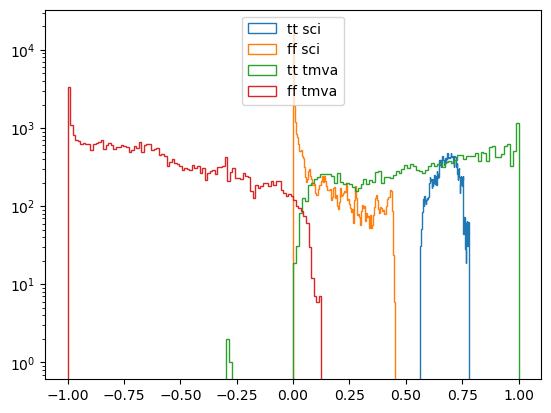

In [114]:
plt.hist(tt_val1, 100, log=True, histtype=u'step', label='tt sci',)
plt.hist(ff_val1, 100, log=True, histtype=u'step', label='ff sci',)
plt.hist(t_val1, 100, log=True, histtype=u'step', label='tt tmva',)
plt.hist(f_val1, 100, log=True, histtype=u'step', label='ff tmva',)
plt.legend(loc='upper center')
plt.show()

2nd dataset

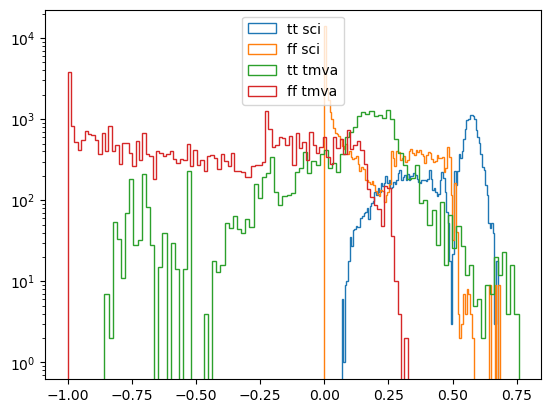

In [113]:
plt.hist(tt_val2, 100, log=True, histtype=u'step', label='tt sci',)
plt.hist(ff_val2, 100, log=True, histtype=u'step', label='ff sci',)
plt.hist(t_val2, 100, log=True, histtype=u'step', label='tt tmva',)
plt.hist(f_val2, 100, log=True, histtype=u'step', label='ff tmva',)
plt.legend(loc='upper center')
plt.show()

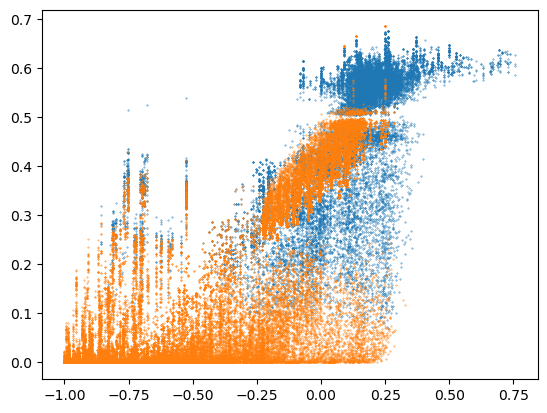

In [170]:
plt.scatter(t_val2, tt_val2, s=0.1)
plt.scatter(f_val2, ff_val2, s=0.1)

3rd dataset

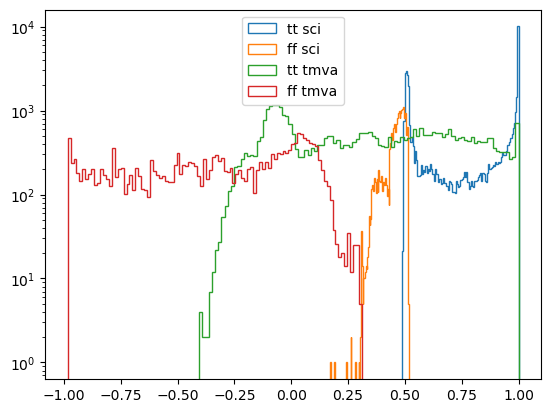

In [112]:
plt.hist(tt_val3, 100, log=True, histtype=u'step', label='tt sci',)
plt.hist(ff_val3, 100, log=True, histtype=u'step', label='ff sci',)
plt.hist(t_val3, 100, log=True, histtype=u'step', label='tt tmva',)
plt.hist(f_val3, 100, log=True, histtype=u'step', label='ff tmva',)
plt.legend(loc='upper center')
plt.show()

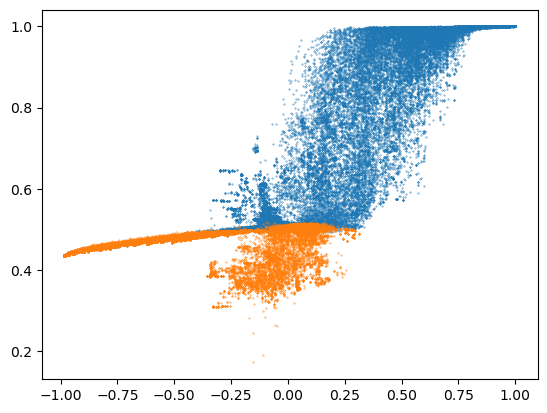

In [171]:
plt.scatter(t_val3, tt_val3, s=0.1)
plt.scatter(f_val3, ff_val3, s=0.1)

xgboost vs adaboost

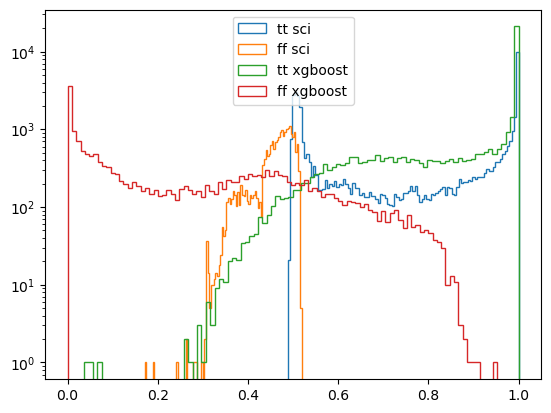

In [163]:
plt.hist(tt_val3, 100, log=True, histtype=u'step', label='tt sci',)
plt.hist(ff_val3, 100, log=True, histtype=u'step', label='ff sci',)
plt.hist(tt_xgb, 100, log=True, histtype=u'step', label='tt xgboost',)
plt.hist(ff_xgb, 100, log=True, histtype=u'step', label='ff xgboost',)
plt.legend(loc='upper center')
plt.show()

## Try now on sklearn dataset about breast cancer

In [189]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


bc = datasets.load_breast_cancer()
X = bc.data
y = bc.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [191]:
p = xgb.predict(X_test)
print(accuracy_score(y_test, p), precision_score(y_test, p), recall_score(y_test, p))
print(confusion_matrix(y_test, p))

0.956140350877193 0.9583333333333334 0.971830985915493
[[40  3]
 [ 2 69]]


In [192]:
## ada_boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
estim = DecisionTreeClassifier(max_depth=6)
model_ada4 = AdaBoostClassifier(estimator = estim, n_estimators=1200, learning_rate=0.02)
model_ada4.fit(X_train ,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.02, n_estimators=1200)

In [195]:
p = model_ada4.predict(X_test)
print(accuracy_score(y_test, p), precision_score(y_test, p), recall_score(y_test, p))
print(confusion_matrix(y_test, p))

0.9385964912280702 0.9444444444444444 0.9577464788732394
[[39  4]
 [ 3 68]]


In [213]:
mdp4_t = model_ada4.predict_proba(X_test[y_test>0])
mdp4_f = model_ada4.predict_proba(X_test[y_test==0])

In [201]:
import ROOT as R
from ROOT import TMVA

# ROOT and TMVA require an open file to store things
# as they go along
outfile = R.TFile('/tmp/tmva_output.root', 'recreate')

factory4 = TMVA.Factory("TMVAClassification", outfile, "AnalysisType=Classification")
dataloader4 = TMVA.DataLoader("datasets4")
for n in range(30):
    dataloader4.AddVariable("f%i"%n, "F")

for y,row in zip(y_train, X_train):
    a = R.vector('double')()
    for r in row:
        a.push_back(r)

    if y > 0:
        dataloader4.AddSignalTrainingEvent(a)
    else:        
        dataloader4.AddBackgroundTrainingEvent(a)
       
for y,row in zip(y_test, X_test):
    a = R.vector('double')() # instantiate a std::vector<double>
    for r in row:
        a.push_back(r)
        
    if y > 0:
        dataloader4.AddSignalTestEvent(a)
    else:        
        dataloader4.AddBackgroundTestEvent(a)

dataloader4.PrepareTrainingAndTestTree(R.TCut("1"), "SplitMode=Random:NormMode=NumEvents")

factory4.BookMethod(dataloader4, TMVA.Types.kBDT, "BDT", 
                   "NTrees=1200:MinNodeSize=1.0:BoostType=AdaBoost:AdaBoostBeta=0.02:SeparationType=GiniIndex:nCuts=14:MaxDepth=6"
                   )
factory4.TrainAllMethods()

from array import array
from sklearn.metrics import classification_report, roc_auc_score
reader4 = TMVA.Reader()
for n in range(30):
    a = array("f", [0.])
    #a = R.vector('double')()
    reader4.AddVariable("f%i"%n, a)
    
reader4.BookMVA("BDT", "datasets4/weights/TMVAClassification_BDT.weights.xml")

prtmva_4 = []
for k, row in enumerate(X_test):
    a = R.vector('double')()
    for r in row:
        a.push_back(r)
    value = reader4.EvaluateMVA(a, "BDT")
    prtmva_4.append(value)


<HEADER> DataSetInfo              : [datasets4] : Added class "Signal"
<HEADER> DataSetInfo              : [datasets4] : Added class "Background"
                         : Add Tree TrainAssignTree_Signal of type Signal with 286 events
                         : Add Tree TestAssignTree_Signal of type Signal with 71 events
                         : Add Tree TrainAssignTree_Background of type Background with 169 events
                         : Add Tree TestAssignTree_Background of type Background with 43 events
                         : Dataset[datasets4] : Class index : 0  name : Signal
                         : Dataset[datasets4] : Class index : 1  name : Background
<HEADER> Factory                  : Booking method: BDT
                         : 
                         : Rebuilding Dataset datasets4
                         : Building event vectors for type 0 Signal
                         : Dataset[datasets4] :  create input formulas for tree TrainAssignTree_Signal
         

0%, time left: unknown
6%, time left: 2 sec
12%, time left: 2 sec
18%, time left: 2 sec
25%, time left: 1 sec
31%, time left: 1 sec
37%, time left: 1 sec
43%, time left: 1 sec
50%, time left: 1 sec
56%, time left: 1 sec
62%, time left: 1 sec
68%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
87%, time left: 0 sec
93%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
31%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
56%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


In [204]:
p = [1 if i > 0 else 0 for i in prtmva_4]
print(accuracy_score(y_test, p), precision_score(y_test, p), recall_score(y_test, p))
print(confusion_matrix(y_test, p))

0.9649122807017544 0.958904109589041 0.9859154929577465
[[40  3]
 [ 1 70]]


In [219]:
prtmva_4t = np.array(prtmva_4)[y_test>0]
prtmva_4f = np.array(prtmva_4)[y_test==0]

Compare sklearn with TMVA

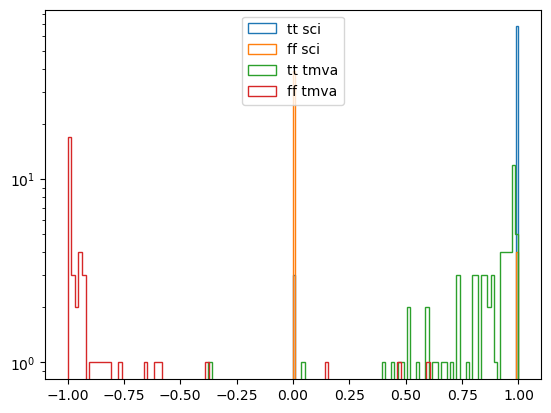

In [221]:

plt.hist(mdp4_t[:,1], 100, log=True, histtype=u'step', label='tt sci',)
plt.hist(mdp4_f[:,1], 100, log=True, histtype=u'step', label='ff sci',)
plt.hist(prtmva_4t, 100, log=True, histtype=u'step', label='tt tmva',)
plt.hist(prtmva_4f, 100, log=True, histtype=u'step', label='ff tmva',)
plt.legend(loc='upper center')
plt.show()